In [37]:
# Importing MNIST
from torchvision.datasets import MNIST
import torch
from torchvision import transforms
import numpy as np
from torch import nn, optim
from torchsummary import summary

# Declaring dataset path
DATASET_PATH = "./data"

train_dataset = MNIST(
    root=DATASET_PATH,      # Directory to store the dataset
    train=True,             # Downloading training set
    download=True           # Downloading the dataset if not present
)

test_dataset = MNIST(
    root=DATASET_PATH,      
    train=False,            # Downloading test set
    download=True
)

The MNIST dataset stands for Modified National Institute of Science and Technology and it is a dataset of that specific organization's database. It consists of a total of 70,000 images which 60,000 are training images and the remaining 10,000 images are for validation. The each image displays a single numerical digits from 0-9 that are curvy shaped and in a handwritten style.
The dimensions of the images consists of a single channel greyscale pixel that has 28x28 height and width.

In [38]:
# Dataset sizes
len(train_dataset), len(test_dataset)

(60000, 10000)

In [39]:
# Image dimensions
image, label = train_dataset[0]
print("Image Shape:", image.size)

Image Shape: (28, 28)


If we get one sample image from the dataset and plot it, we get a blurry digit that is difficult to recognize even by humans. Thus, we need to preprocess it.

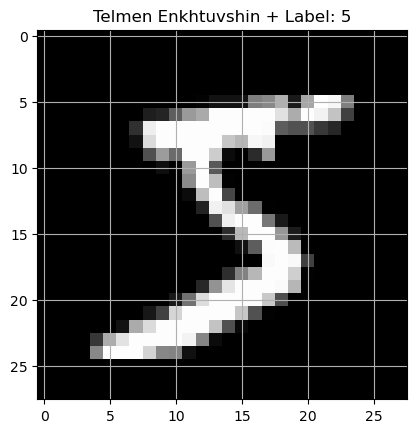

In [40]:
import matplotlib.pyplot as plt

# Convert the tensor to a NumPy array and plot
plt.imshow(np.array(image), cmap="gray")
plt.title(f"Telmen Enkhtuvshin + Label: {label}")
plt.grid()
plt.show()

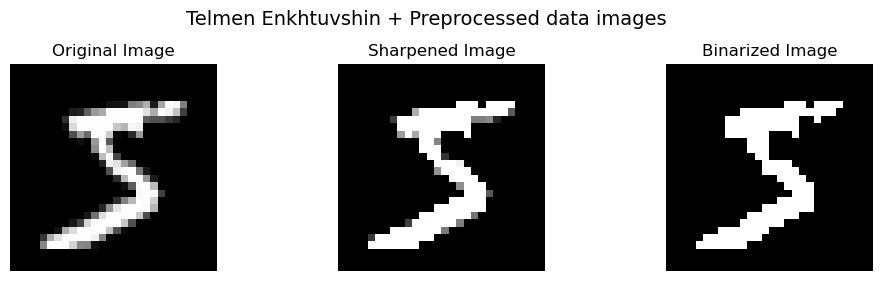

In [41]:
from PIL import Image, ImageEnhance, ImageFilter

# # Convert PyTorch Tensor back to PIL Image
# to_pil = transforms.ToPILImage()
# image = to_pil(image)  # Now it's a PIL Image

# Convert to PIL Image (original MNIST is already PIL format)
image = image.convert("L")  # Convert to grayscale

# Step 1: Enhance Contrast
enhancer = ImageEnhance.Contrast(image)
image_contrast = enhancer.enhance(2.0)  # Increase contrast (adjust value as needed)

# Step 2: Sharpen the Image
image_sharpened = image_contrast.filter(ImageFilter.SHARPEN)

# Step 3: Apply Binarization (Thresholding)
threshold = 127  # Set threshold for binarization
image_bw = image_sharpened.point(lambda p: 255 if p > threshold else 0)  # Convert to black & white

# Plot Original vs Processed Image
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(image_sharpened, cmap="gray")
axs[1].set_title("Sharpened Image")
axs[1].axis("off")

axs[2].imshow(image_bw, cmap="gray")
axs[2].set_title("Binarized Image")
axs[2].axis("off")

fig.suptitle("Telmen Enkhtuvshin + Preprocessed data images", fontsize=14)
fig.subplots_adjust(top=0.8)  # Increase space between suptitle and subplots


plt.show()

# This looks much better. Now we will preprocess the whole dataset.

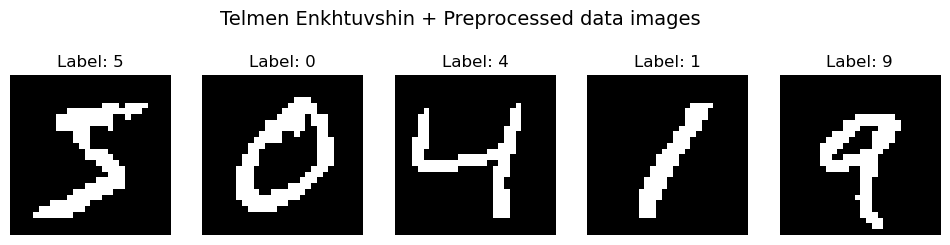

In [62]:
# Define a custom transformation function
def preprocess_mnist(image):
    """Enhance contrast, sharpen, and binarize MNIST images"""
    
    # Convert to grayscale (already grayscale but ensures compatibility)
    image = image.convert("L")

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)  # Adjust contrast level as needed

    # Sharpen the image
    image = image.filter(ImageFilter.SHARPEN)

    # Apply binarization (Thresholding)
    threshold = 127
    image = image.point(lambda p: 255 if p > threshold else 0)  # Convert to black & white

    return image

# Define transformation pipeline (including our custom function)
transform_pipeline = transforms.Compose([
    transforms.Lambda(preprocess_mnist),  # Apply preprocessing
    transforms.ToTensor()  # Convert to PyTorch tensor for training
])

# Load the MNIST dataset with preprocessing
# Train dataset
mnist_train_dataset = MNIST(root="./data", train=True, transform=transform_pipeline, download=True)
# Test dataset
mnist_test_dataset = MNIST(root="./data", train=False, transform=transform_pipeline, download=True)

# Check a few images after preprocessing
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):  # Show first 5 images
    image, label = mnist_train_dataset[i]  # Get preprocessed image and label
    axs[i].imshow(image.squeeze(), cmap="gray")  # Remove extra dimensions for visualization
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

fig.suptitle("Telmen Enkhtuvshin + Preprocessed data images", fontsize=14)
plt.show()

In [63]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=64, shuffle=False)

In [98]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # First Convolutional Layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            # ReLU activation function
            nn.ReLU(),
            # First Pooling Layer
            nn.MaxPool2d(2, 2),  
            # Second Convolutional Layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # ReLU for second conv layer
            nn.ReLU(),
            # Second Pooling Layer
            nn.MaxPool2d(2, 2),
            # Third Convolutional Layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # ReLU for thrid conv layer
            nn.ReLU(),
            # Third Pooling Layer
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            # Flattening image nodes for linear
            nn.Flatten(),
            # Fully connected linear layer
            nn.Linear(128 * 3 * 3, 128), 
            # Activation Layer
            nn.ReLU(),
            # Output layer
            nn.Linear(128, 10)  
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [99]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """
    Train and validate a PyTorch model.
    
    Args:
        model: PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        trainloader: DataLoader for training data.
        validloader: DataLoader for validation data.
        epochs: Number of epochs for training.
        verbose: If True, print progress for each epoch.
    
    Returns:
        A dictionary containing training loss, validation loss, and validation accuracy.
    """
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad() # Reset gradients
            y_hat = model(X) # Forward pass: compute the model's prediction
            loss = criterion(y_hat, y.type(torch.long)) # Compute loss between predicted values and actual labels
            loss.backward() # Backpropagation: compute gradients
            optimizer.step() # Update model parameters using optimizer
            train_batch_loss += loss.item() # Accumulate batch loss
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X) # Forward pass: compute predictions for validation set
                y_hat_labels = torch.argmax(y_hat, dim=1) # Apply sigmoid activation and classify outputs (threshold at 0.5)
                loss = criterion(y_hat, y.type(torch.long)) # Compute validation loss
                valid_batch_loss += loss.item() # Accumulate validation batch loss
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item() # Compute validation accuracy: compare predicted labels to actual labels
        valid_loss.append(valid_batch_loss / len(validloader)) # Compute average validation loss for this epoch
        valid_accuracy.append(valid_batch_acc / len(validloader))  # Compute average validation accuracy for this epoch
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results   

In [100]:
#Define and Train model
model = MNIST_CNN()

# Print summary
summary(model, (1, 28, 28))

# Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
results = trainer(model, criterion, optimizer, train_loader, test_loader, epochs=50)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                  [-1, 128]         147,584
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 241,546
Trainable params:

We have trained our model to have high accuracy and low loss. Now, we will save our model.

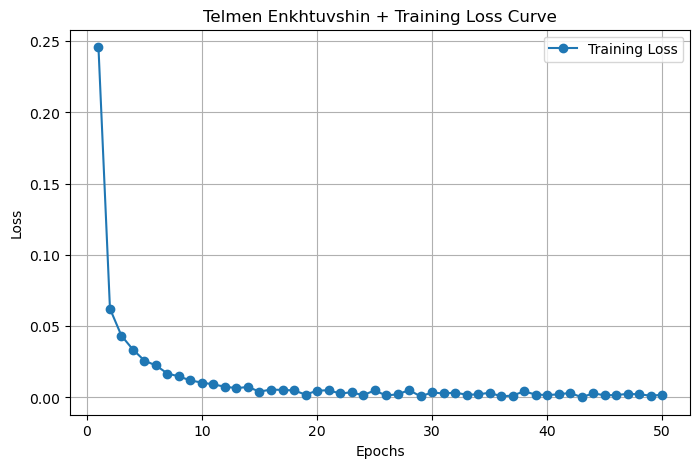

In [101]:
import matplotlib.pyplot as plt

# Extract metrics from the results dictionary
train_loss = results["train_loss"]       # Training loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o')  # Training loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Training Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

This is a phenomenal result. The training loss is decreasing steadily until it comes to near zero. But, it is not exactly zero, and some loss is still there. This means, our model is not overfitting and is working exactly as expected.

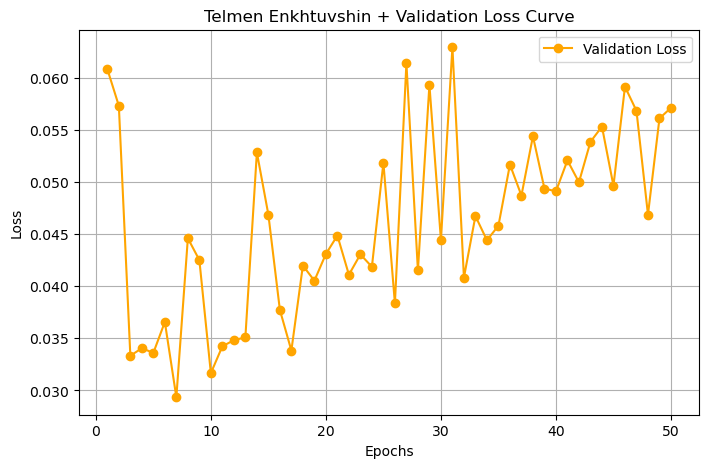

In [102]:
# Extract metrics from the results dictionary
valid_loss = results["valid_loss"]       # Validation loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation Loss", marker='o', color="orange")  # Validation loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Validation Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

Here, our Validation loss went down steadily but started to increase again. But don't let this trend fool us. The actual range of loss is miniscule and our model is not overfitting. The performance of the model plateaus at the later epochs.

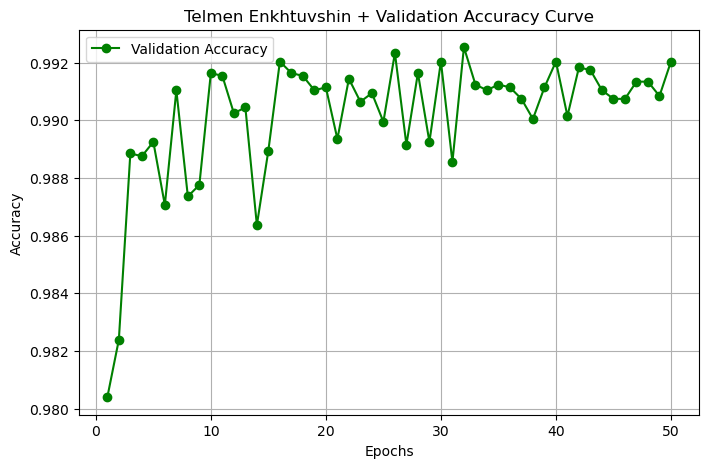

In [103]:
# Extract metrics from the results dictionary
valid_acc = results["valid_accuracy"]       # Validation accuracy per epoch


# Plot Training and Validation Accuracy Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_acc) + 1), valid_acc, label="Validation Accuracy", marker='o', color="green")  # Validation Accuracy
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Validation Accuracy Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

Here, we also have a great result. Our validation accuracy increased significantly around the first epochs and the result is proficient. The accuracy plateaus as the epochs go by and the model does not have 100% accuracy in the end. That indicates the model is behaving as expected and no overfitiing is happening. If more epochs are introduced, it will be useless computation that does not improve the performance of the model at all as it has already reached the highest performance level.

In [104]:
# Ensure model is in evaluation mode
model.eval()

# Get a batch of test images and labels
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move data to the appropriate device (if we are using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)
model.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Get the class index with the highest probability

# Convert tensors to CPU for visualization
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

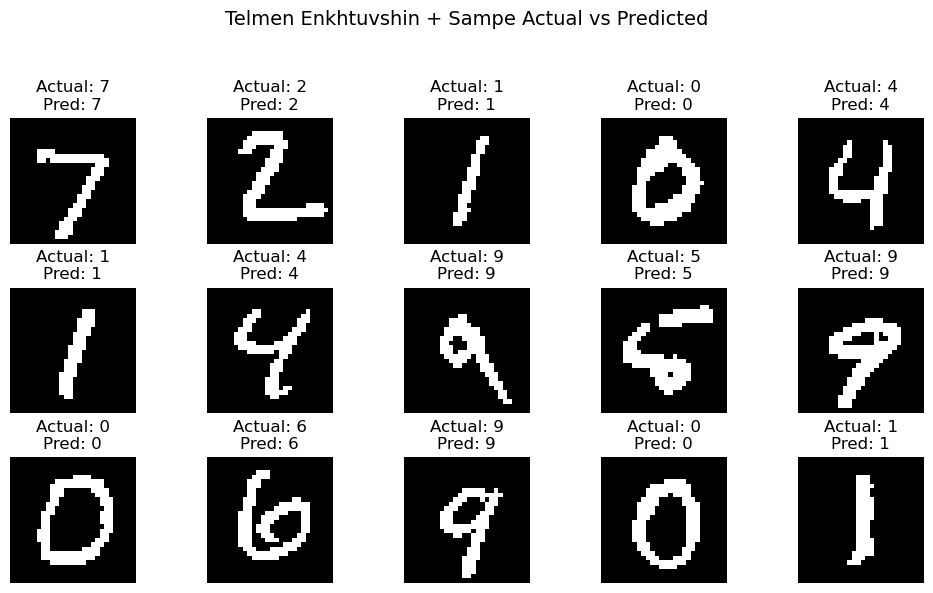

In [105]:
def plot_images(images, labels, preds):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    axes = axes.flatten()
    
    for i in range(15):
        img = images[i].squeeze().numpy()  # Removing extra dimensions
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Actual: {labels[i].item()}\nPred: {preds[i].item()}")
        axes[i].axis("off")

    plt.tight_layout()
    fig.suptitle("Telmen Enkhtuvshin + Sampe Actual vs Predicted", fontsize=14)
    fig.subplots_adjust(top=0.8)
    plt.show()

plot_images(images, labels, predicted)

Our model has an accuracy score of 99.20% which is a good performance.

In [106]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.20%


We will now test for incorrect values in the current sample batch

In [107]:
incorrect_idx = (predicted != labels).nonzero(as_tuple=True)[0]  # Get indices of incorrect predictions

if len(incorrect_idx) > 0:
    incorrect_images = images[incorrect_idx[:15]]
    incorrect_labels = labels[incorrect_idx[:15]]
    incorrect_preds = predicted[incorrect_idx[:15]]

    plot_images(incorrect_images, incorrect_labels, incorrect_preds)
else:
    print("No incorrect predictions found in this batch!")

No incorrect predictions found in this batch!


In the next cell, we are storing actual and predicted labels to visualize our results.

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Store actual and predicted values
actual_labels = []
predicted_labels = []

# Processing actual and predicted values
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Find incorrect predictions
        incorrect_mask = preds != labels
        incorrect_labels = labels[incorrect_mask].cpu().numpy()

        # Count incorrect predictions per digit
        for label in incorrect_labels:
            incorrect_counts[label] += 1
        
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Final actual and predicted labels
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

Here, we are plotting the correct and incorrect results on a plot with varying opacity to indicate common and uncommon mistakes.

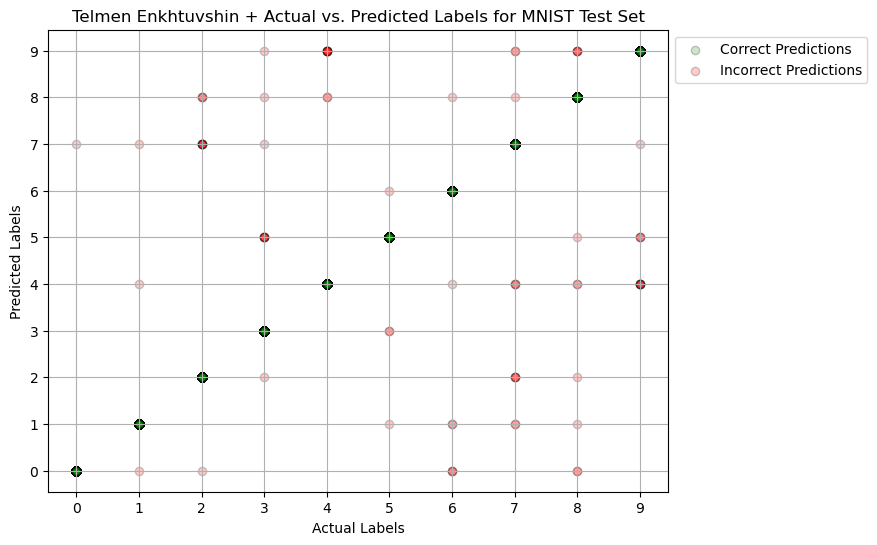

In [109]:
# Identify correct and incorrect predictions
correct_indices = np.where(actual_labels == predicted_labels)[0]
incorrect_indices = np.where(actual_labels != predicted_labels)[0]

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Plot correct predictions in green
plt.scatter(actual_labels[correct_indices], predicted_labels[correct_indices], 
            color="green", label="Correct Predictions", alpha=0.2, edgecolors="k")

# Plot incorrect predictions in red
plt.scatter(actual_labels[incorrect_indices], predicted_labels[incorrect_indices], 
            color="red", label="Incorrect Predictions", alpha=0.2, edgecolors="k")

# Labels and title
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.title("Telmen Enkhtuvshin + Actual vs. Predicted Labels for MNIST Test Set")

# X and Y ticks for digits 0-9
plt.xticks(range(10))
plt.yticks(range(10))
plt.grid(True)

# Add legend to differentiate correct and incorrect predictions
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

Here, we are plotting the confusion matrix to analyze the accuracy of our model with numbers.

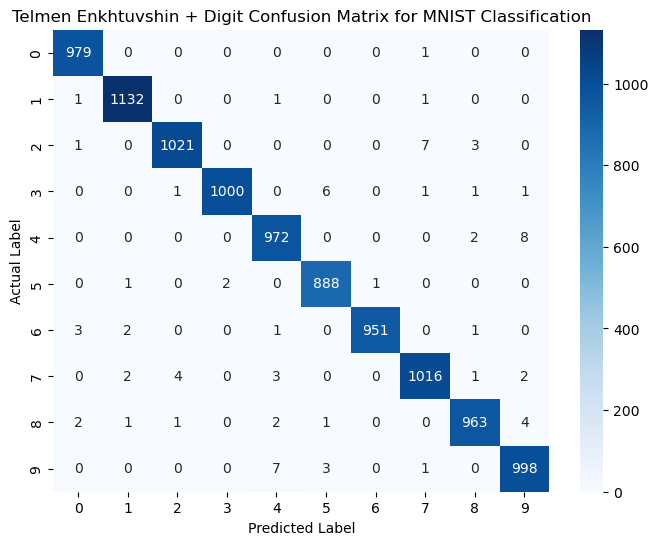

In [110]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Telmen Enkhtuvshin + Digit Confusion Matrix for MNIST Classification")
plt.show()

In the Confusion Matrix above, we have a very pleasing heatmap that indicates most of the predicted digits are correct. But our model is not perfect and we see some incorrect predictions too. Let's plot the incorrect occurences on a different plot.

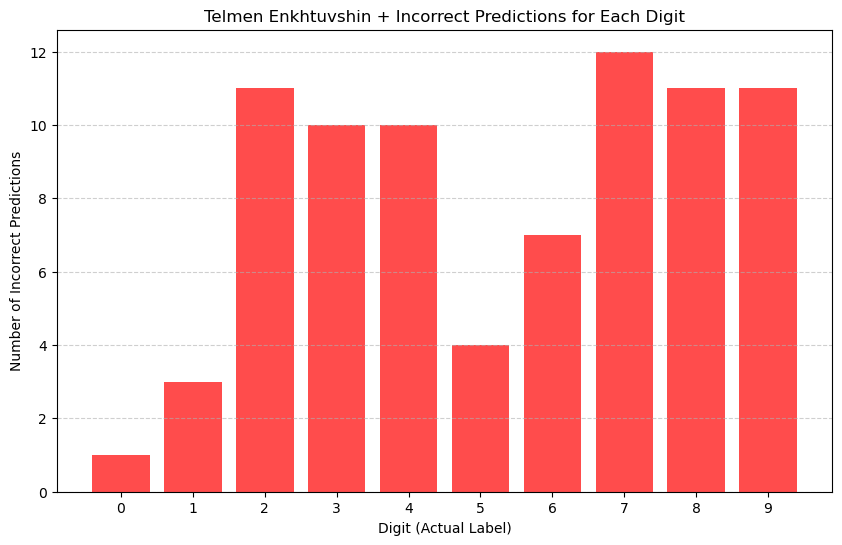

In [117]:
# Convert dictionary to lists for plotting
digits = list(incorrect_counts.keys())
errors = list(incorrect_counts.values())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(digits, errors, color='red', alpha=0.7)
plt.xlabel("Digit (Actual Label)")
plt.ylabel("Number of Incorrect Predictions")
plt.title("Telmen Enkhtuvshin + Incorrect Predictions for Each Digit")
plt.xticks(digits)  # Ensure all digits are labeled
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

Now that we have plotted the incorrect values, it seems like the most of the mistakes are happenning with the digits that have multiple and complex brushstrokes. For example, the digit that has the most mistakes is digit 7 with 12 incorrect predictions. This is a vague number which there can be instances where it is confused as a different digit based on its shape.

In [115]:
# Save model
PATH = "myModels/m-2.pt" # Add path
torch.save(model, PATH)

Overall, my model is behaving with high performance as well as low inaccuracy, which is exactly what is expected.